## Rossler Attractor
$\begin{cases} \frac{d\,u_1}{dt} = - u_2 \\ \frac{d\,u_2}{dt} = u_1 + \alpha\,u_2  \end{cases}$

In [1]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def load_data_inv():
    data = sio.loadmat("../dataset/Rossler.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.1
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

In [3]:
def ode_fn(t,u,a):
    x, y = tf.split(u, 2, axis=-1)
    x_t, y_t = tf.gradients(x,t)[0], tf.gradients(y,t)[0]
    
    f1 = x_t + y
    f2 = y_t - x - a*y
    
    return tf.concat([f1,f2], axis=-1)

In [10]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    u1_train, u2_train = u_train[:, 0:1], u_train[:, 1:2]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=2),
    )
    process_r1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=1, sigma=1),
    )
    
    # build likelihood
    likelihood_u12 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u2_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 1]],
        sigma=noise,
    )
    
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_r1],
        pde=ode_fn,
        sigma=noise,
    )
    
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_r1],
        likelihoods=[likelihood_u12, likelihood_f],
    )
    
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=2000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=777,
    )
    model.compile(method)
    
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))
    
    processes = [process_u, process_r1]

    return processes, samples, model

@neuq.utils.timer
def Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    u1_train, u2_train = u_train[:, 0:1], u_train[:, 1:2]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(
            layers=layers, regularizer=tf.keras.regularizers.l2(1e-7)
        ),
    )
    process_r1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    
    # build likelihood
    likelihood_u12 = neuq.likelihoods.MSE(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u2_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 1]],
    )
    
    likelihood_f = neuq.likelihoods.MSE(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_r1],
        pde=ode_fn,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_r1],
        likelihoods=[likelihood_u12, likelihood_f],
    )
    # assign and compile method
    method = neuq.inferences.DEns(
        num_samples=20, num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    samples = neuq.utils.batch_samples(samples)  # reshape

    processes = [process_u, process_r1]
    return processes, samples, model

################## Load data and specify some hyperparameters ####################
t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test = load_data_inv()

layers = [1, 100, 100, 2]

In [11]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred = np.split(u_pred, 2, axis=-1)
    u1_test, u2_test = np.split(u_test, 2, axis=-1)
    u1_train, u2_train = u_train[:,0:1], u_train[:,1:2]  # training data

    neuq.utils.hist(r1_pred, name=r"value of $a$")
    
    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
    )
    neuq.utils.plot1d(
        t_u_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
    )

In [12]:
############################### Choose framework #################################
processes, samples, model = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

#processes, samples, model = Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.457 

Execution time for 'Samplable' function is: 253.912 s, 4.232 mins


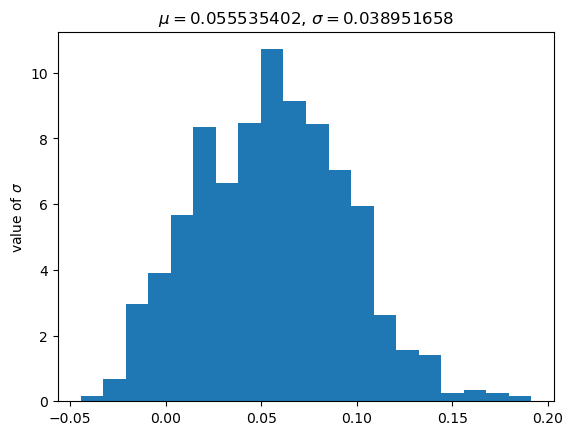

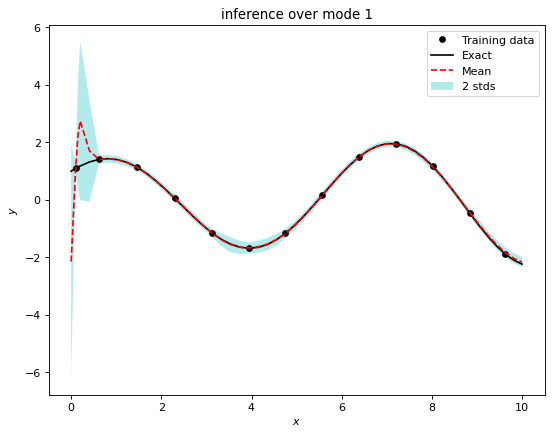

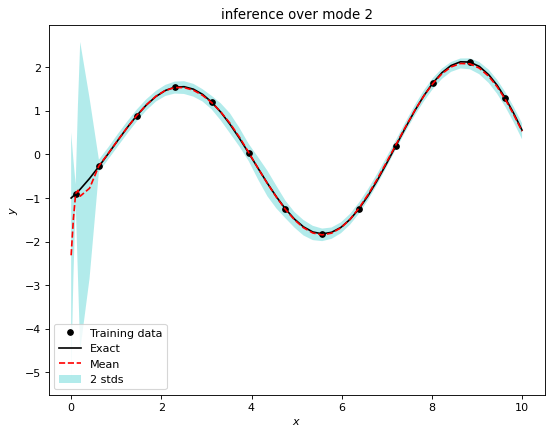

In [13]:
u_pred, r1_pred = model.predict(t_test, samples, processes, pde_fn=None)
plots(u_pred, t_test, u_test, t_u_train, u_train)

In [8]:
############################### Choose framework #################################
#processes, samples, model = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

processes, samples, model = Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers)

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...
Iteration:  0 , loss:  1.5884582
Iteration:  100 , loss:  1.3402861
Iteration:  200 , loss:  1.0744255
Iteration:  300 , loss:  0.5797645
Iteration:  400 , loss:  0.270101
Iteration:  500 , loss:  0.15555288
Iteration:  600 , loss:  0.0943564
Iteration:  700 , loss:  0.066850595
Iteration:  800 , loss:  0.05014851
Iteration:  900 , loss:  0.039166078
Iteration:  1000 , loss:  0.03150227
Iteration:  1100 , loss:  0.026514009
Iteration:  1200 , loss:  0.02202964
Iteration:  1300 , loss:  0.017784525
Iteration:  1400 , loss:  0.01395874
Iteration:  1500 , loss:  0.011064645
Iteration:  1600 , loss:  0.008915941
Iteration:  1700 , loss:  0.0073562623
Iteration:  1800 , loss:  0.0097810775
Iteration:  1900 , loss:  0.00568104
Iteration:  2000 , loss:  0.0052393377
Iteration:  2100 , loss:  0.004904749
Iteration:  2200 , loss:  0.004650557
Iteration:  2300 , loss:  0.0044155796
Ite

Iteration:  600 , loss:  0.13400716
Iteration:  700 , loss:  0.07870097
Iteration:  800 , loss:  0.051420078
Iteration:  900 , loss:  0.036557633
Iteration:  1000 , loss:  0.027297007
Iteration:  1100 , loss:  0.021552553
Iteration:  1200 , loss:  0.0175581
Iteration:  1300 , loss:  0.014301524
Iteration:  1400 , loss:  0.011364651
Iteration:  1500 , loss:  0.008654745
Iteration:  1600 , loss:  0.006622086
Iteration:  1700 , loss:  0.0046201576
Iteration:  1800 , loss:  0.003477636
Iteration:  1900 , loss:  0.002776996
Iteration:  2000 , loss:  0.0021168878
Iteration:  2100 , loss:  0.0018385281
Iteration:  2200 , loss:  0.0018894492
Iteration:  2300 , loss:  0.0021134366
Iteration:  2400 , loss:  0.001686386
Iteration:  2500 , loss:  0.0011461714
Iteration:  2600 , loss:  0.0010799175
Iteration:  2700 , loss:  0.0010965985
Iteration:  2800 , loss:  0.00091999845
Iteration:  2900 , loss:  0.0010414644
Iteration:  3000 , loss:  0.0008827902
Iteration:  3100 , loss:  0.0008713666
Iterati

Iteration:  1300 , loss:  0.020123847
Iteration:  1400 , loss:  0.01574902
Iteration:  1500 , loss:  0.012245059
Iteration:  1600 , loss:  0.009926087
Iteration:  1700 , loss:  0.008475064
Iteration:  1800 , loss:  0.0071291476
Iteration:  1900 , loss:  0.0062592984
Iteration:  2000 , loss:  0.005435112
Iteration:  2100 , loss:  0.0047336835
Iteration:  2200 , loss:  0.004007841
Iteration:  2300 , loss:  0.0032989471
Iteration:  2400 , loss:  0.0029081535
Iteration:  2500 , loss:  0.0022534288
Iteration:  2600 , loss:  0.0018803168
Iteration:  2700 , loss:  0.0015404121
Iteration:  2800 , loss:  0.001302668
Iteration:  2900 , loss:  0.0011133046
Iteration:  3000 , loss:  0.00097217475
Iteration:  3100 , loss:  0.00086933526
Iteration:  3200 , loss:  0.00077698333
Iteration:  3300 , loss:  0.0007143425
Iteration:  3400 , loss:  0.00066641654
Iteration:  3500 , loss:  0.0006353366
Iteration:  3600 , loss:  0.0009560287
Iteration:  3700 , loss:  0.0018727019
Iteration:  3800 , loss:  0.00

Iteration:  1900 , loss:  0.005160312
Iteration:  2000 , loss:  0.004631591
Iteration:  2100 , loss:  0.0041315346
Iteration:  2200 , loss:  0.003550626
Iteration:  2300 , loss:  0.0027857719
Iteration:  2400 , loss:  0.0021448778
Iteration:  2500 , loss:  0.0015829722
Iteration:  2600 , loss:  0.0011556626
Iteration:  2700 , loss:  0.0009421555
Iteration:  2800 , loss:  0.00070272776
Iteration:  2900 , loss:  0.0006084562
Iteration:  3000 , loss:  0.00059475296
Iteration:  3100 , loss:  0.0005525778
Iteration:  3200 , loss:  0.0005024322
Iteration:  3300 , loss:  0.00048845494
Iteration:  3400 , loss:  0.0005327185
Iteration:  3500 , loss:  0.0004697526
Iteration:  3600 , loss:  0.0004638508
Iteration:  3700 , loss:  0.00049362215
Iteration:  3800 , loss:  0.00045412173
Iteration:  3900 , loss:  0.00047009435
Iteration:  4000 , loss:  0.0004486639
Iteration:  4100 , loss:  0.0017186545
Iteration:  4200 , loss:  0.0004422133
Iteration:  4300 , loss:  0.00045335805
Iteration:  4400 , lo

Iteration:  2700 , loss:  0.0032793684
Iteration:  2800 , loss:  0.0029714687
Iteration:  2900 , loss:  0.0026640098
Iteration:  3000 , loss:  0.0023765962
Iteration:  3100 , loss:  0.0022385137
Iteration:  3200 , loss:  0.0018157199
Iteration:  3300 , loss:  0.0017342414
Iteration:  3400 , loss:  0.0013505948
Iteration:  3500 , loss:  0.001315803
Iteration:  3600 , loss:  0.0009809436
Iteration:  3700 , loss:  0.00084624917
Iteration:  3800 , loss:  0.00073722453
Iteration:  3900 , loss:  0.0016296334
Iteration:  4000 , loss:  0.00069553056
Iteration:  4100 , loss:  0.00054097956
Iteration:  4200 , loss:  0.0005748595
Iteration:  4300 , loss:  0.00048429542
Iteration:  4400 , loss:  0.0018768708
Iteration:  4500 , loss:  0.00045060983
Iteration:  4600 , loss:  0.00044594915
Iteration:  4700 , loss:  0.0005076128
Iteration:  4800 , loss:  0.0004442981
Iteration:  4900 , loss:  0.00042423536
Iteration:  5000 , loss:  0.00042263867
Iteration:  5100 , loss:  0.00041871858
Iteration:  5200

Iteration:  3400 , loss:  0.0005228232
Iteration:  3500 , loss:  0.00050354673
Iteration:  3600 , loss:  0.000491957
Iteration:  3700 , loss:  0.00047613974
Iteration:  3800 , loss:  0.00049907906
Iteration:  3900 , loss:  0.0004565583
Iteration:  4000 , loss:  0.00050040695
Iteration:  4100 , loss:  0.00044168092
Iteration:  4200 , loss:  0.00043486446
Iteration:  4300 , loss:  0.0004603741
Iteration:  4400 , loss:  0.00042367566
Iteration:  4500 , loss:  0.0004184803
Iteration:  4600 , loss:  0.00041547976
Iteration:  4700 , loss:  0.00040969969
Iteration:  4800 , loss:  0.00040560894
Iteration:  4900 , loss:  0.0004031828
Iteration:  5000 , loss:  0.00039801543
Iteration:  5100 , loss:  0.0006761434
Iteration:  5200 , loss:  0.00039141942
Iteration:  5300 , loss:  0.0004190989
Iteration:  5400 , loss:  0.00040670388
Iteration:  5500 , loss:  0.00038254648
Iteration:  5600 , loss:  0.00038117086
Iteration:  5700 , loss:  0.0003773452
Iteration:  5800 , loss:  0.0003759022
Iteration: 

Iteration:  3900 , loss:  0.00044347567
Iteration:  4000 , loss:  0.00044041182
Iteration:  4100 , loss:  0.0004630258
Iteration:  4200 , loss:  0.0004426144
Iteration:  4300 , loss:  0.0004668656
Iteration:  4400 , loss:  0.0005545368
Iteration:  4500 , loss:  0.00050432666
Iteration:  4600 , loss:  0.00043116388
Iteration:  4700 , loss:  0.00097556214
Iteration:  4800 , loss:  0.000420532
Iteration:  4900 , loss:  0.0012525473
Iteration:  5000 , loss:  0.00046041992
Iteration:  5100 , loss:  0.001106318
Iteration:  5200 , loss:  0.00062117673
Iteration:  5300 , loss:  0.00041482272
Iteration:  5400 , loss:  0.0014495123
Iteration:  5500 , loss:  0.00040605094
Iteration:  5600 , loss:  0.00040642984
Iteration:  5700 , loss:  0.00040255007
Iteration:  5800 , loss:  0.0004012596
Iteration:  5900 , loss:  0.0004069585
Iteration:  6000 , loss:  0.0010766586
Iteration:  6100 , loss:  0.0008112977
Iteration:  6200 , loss:  0.00039646606
Iteration:  6300 , loss:  0.00039104844
Iteration:  64

Iteration:  4500 , loss:  0.00083130563
Iteration:  4600 , loss:  0.0009800765
Iteration:  4700 , loss:  0.001098253
Iteration:  4800 , loss:  0.0008126836
Iteration:  4900 , loss:  0.0022146008
Iteration:  5000 , loss:  0.001343321
Iteration:  5100 , loss:  0.00073781767
Iteration:  5200 , loss:  0.0006982705
Iteration:  5300 , loss:  0.00072591985
Iteration:  5400 , loss:  0.0006952421
Iteration:  5500 , loss:  0.00066370517
Iteration:  5600 , loss:  0.0006528607
Iteration:  5700 , loss:  0.00064446684
Iteration:  5800 , loss:  0.00063526555
Iteration:  5900 , loss:  0.00062868017
Iteration:  6000 , loss:  0.00078844547
Iteration:  6100 , loss:  0.00065610016
Iteration:  6200 , loss:  0.0006200516
Iteration:  6300 , loss:  0.0006068072
Iteration:  6400 , loss:  0.001651187
Iteration:  6500 , loss:  0.0014888182
Iteration:  6600 , loss:  0.00066611654
Iteration:  6700 , loss:  0.00059066724
Iteration:  6800 , loss:  0.0007988563
Iteration:  6900 , loss:  0.00079978176
Iteration:  7000

Iteration:  5200 , loss:  0.0029207172
Iteration:  5300 , loss:  0.00041275646
Iteration:  5400 , loss:  0.0012481088
Iteration:  5500 , loss:  0.00041315597
Iteration:  5600 , loss:  0.0004112135
Iteration:  5700 , loss:  0.00040549692
Iteration:  5800 , loss:  0.00041462298
Iteration:  5900 , loss:  0.00040287216
Iteration:  6000 , loss:  0.0004159944
Iteration:  6100 , loss:  0.0012918182
Iteration:  6200 , loss:  0.00039861017
Iteration:  6300 , loss:  0.00040371277
Iteration:  6400 , loss:  0.00039619068
Iteration:  6500 , loss:  0.00040449444
Iteration:  6600 , loss:  0.000394613
Iteration:  6700 , loss:  0.0003969983
Iteration:  6800 , loss:  0.00048610434
Iteration:  6900 , loss:  0.0005852271
Iteration:  7000 , loss:  0.0003902795
Iteration:  7100 , loss:  0.00041630687
Iteration:  7200 , loss:  0.0003904907
Iteration:  7300 , loss:  0.00038770383
Iteration:  7400 , loss:  0.0005537267
Iteration:  7500 , loss:  0.0003962611
Iteration:  7600 , loss:  0.0007199858
Iteration:  77

Iteration:  6000 , loss:  0.00037858644
Iteration:  6100 , loss:  0.0003801564
Iteration:  6200 , loss:  0.00037522905
Iteration:  6300 , loss:  0.0003741019
Iteration:  6400 , loss:  0.00037108446
Iteration:  6500 , loss:  0.00037112262
Iteration:  6600 , loss:  0.0003681596
Iteration:  6700 , loss:  0.00036688865
Iteration:  6800 , loss:  0.0008157091
Iteration:  6900 , loss:  0.00036451797
Iteration:  7000 , loss:  0.00036332844
Iteration:  7100 , loss:  0.0009873948
Iteration:  7200 , loss:  0.000559027
Iteration:  7300 , loss:  0.00036081928
Iteration:  7400 , loss:  0.00038535893
Iteration:  7500 , loss:  0.0005378352
Iteration:  7600 , loss:  0.00040389606
Iteration:  7700 , loss:  0.0003582045
Iteration:  7800 , loss:  0.00035735482
Iteration:  7900 , loss:  0.0003579718
Iteration:  8000 , loss:  0.0003861072
Iteration:  8100 , loss:  0.0003558428
Iteration:  8200 , loss:  0.00037494564
Iteration:  8300 , loss:  0.00035498347
Iteration:  8400 , loss:  0.00035543967
Iteration:  

Iteration:  6600 , loss:  0.00039844614
Iteration:  6700 , loss:  0.00037455212
Iteration:  6800 , loss:  0.00039328638
Iteration:  6900 , loss:  0.0004533362
Iteration:  7000 , loss:  0.00037091787
Iteration:  7100 , loss:  0.00040334798
Iteration:  7200 , loss:  0.00037646113
Iteration:  7300 , loss:  0.0013203335
Iteration:  7400 , loss:  0.00037713107
Iteration:  7500 , loss:  0.0012472442
Iteration:  7600 , loss:  0.0004874639
Iteration:  7700 , loss:  0.000521275
Iteration:  7800 , loss:  0.0004268448
Iteration:  7900 , loss:  0.0003628621
Iteration:  8000 , loss:  0.0012773592
Iteration:  8100 , loss:  0.0011387004
Iteration:  8200 , loss:  0.00036067
Iteration:  8300 , loss:  0.00036044515
Iteration:  8400 , loss:  0.0003600786
Iteration:  8500 , loss:  0.0005389922
Iteration:  8600 , loss:  0.00035807892
Iteration:  8700 , loss:  0.00038879528
Iteration:  8800 , loss:  0.00039899314
Iteration:  8900 , loss:  0.00035683514
Iteration:  9000 , loss:  0.00050314335
Iteration:  910

Iteration:  7400 , loss:  0.00041409678
Iteration:  7500 , loss:  0.00047672488
Iteration:  7600 , loss:  0.00040310388
Iteration:  7700 , loss:  0.0004110082
Iteration:  7800 , loss:  0.00040843448
Iteration:  7900 , loss:  0.00052250555
Iteration:  8000 , loss:  0.0008409876
Iteration:  8100 , loss:  0.0004013935
Iteration:  8200 , loss:  0.0004118471
Iteration:  8300 , loss:  0.00040176895
Iteration:  8400 , loss:  0.0005424773
Iteration:  8500 , loss:  0.00042405986
Iteration:  8600 , loss:  0.00040014333
Iteration:  8700 , loss:  0.00040867238
Iteration:  8800 , loss:  0.00039927804
Iteration:  8900 , loss:  0.00040266154
Iteration:  9000 , loss:  0.00044663373
Iteration:  9100 , loss:  0.00039845545
Iteration:  9200 , loss:  0.00051169796
Iteration:  9300 , loss:  0.00040925085
Iteration:  9400 , loss:  0.00041290227
Iteration:  9500 , loss:  0.0012148104
Iteration:  9600 , loss:  0.00048301154
Iteration:  9700 , loss:  0.00039686586
Iteration:  9800 , loss:  0.00042820326
Iterat

Iteration:  8100 , loss:  0.00043615774
Iteration:  8200 , loss:  0.00044184132
Iteration:  8300 , loss:  0.00043378348
Iteration:  8400 , loss:  0.0004504022
Iteration:  8500 , loss:  0.00043231176
Iteration:  8600 , loss:  0.00043064854
Iteration:  8700 , loss:  0.0004307445
Iteration:  8800 , loss:  0.0004289607
Iteration:  8900 , loss:  0.00043291494
Iteration:  9000 , loss:  0.0004471402
Iteration:  9100 , loss:  0.0013779385
Iteration:  9200 , loss:  0.00042461226
Iteration:  9300 , loss:  0.0004271291
Iteration:  9400 , loss:  0.0004338085
Iteration:  9500 , loss:  0.00042195813
Iteration:  9600 , loss:  0.00042196346
Iteration:  9700 , loss:  0.0004252592
Iteration:  9800 , loss:  0.00056920387
Iteration:  9900 , loss:  0.0006326974
Iteration:  10000 , loss:  0.00041795307
Iteration:  10100 , loss:  0.00041991094
Iteration:  10200 , loss:  0.00042013146
Iteration:  10300 , loss:  0.00091317535
Iteration:  10400 , loss:  0.00041736272
Iteration:  10500 , loss:  0.00041439768
Ite

Iteration:  8700 , loss:  0.0003391072
Iteration:  8800 , loss:  0.00033867493
Iteration:  8900 , loss:  0.0018251826
Iteration:  9000 , loss:  0.0013510471
Iteration:  9100 , loss:  0.00033719273
Iteration:  9200 , loss:  0.00034110225
Iteration:  9300 , loss:  0.00033863517
Iteration:  9400 , loss:  0.00081662735
Iteration:  9500 , loss:  0.00033576813
Iteration:  9600 , loss:  0.00033643487
Iteration:  9700 , loss:  0.00035322295
Iteration:  9800 , loss:  0.00078016944
Iteration:  9900 , loss:  0.00037405075
Iteration:  10000 , loss:  0.0003377218
Iteration:  10100 , loss:  0.00034245514
Iteration:  10200 , loss:  0.00033364445
Iteration:  10300 , loss:  0.00033435764
Iteration:  10400 , loss:  0.00034378283
Iteration:  10500 , loss:  0.00052392454
Iteration:  10600 , loss:  0.0003324393
Iteration:  10700 , loss:  0.00034090795
Iteration:  10800 , loss:  0.00033340583
Iteration:  10900 , loss:  0.00083451986
Iteration:  11000 , loss:  0.001287129
Iteration:  11100 , loss:  0.0003311

Iteration:  9300 , loss:  0.00037445617
Iteration:  9400 , loss:  0.0003768413
Iteration:  9500 , loss:  0.0003729888
Iteration:  9600 , loss:  0.00037827733
Iteration:  9700 , loss:  0.00037239172
Iteration:  9800 , loss:  0.00037093286
Iteration:  9900 , loss:  0.00038283414
Iteration:  10000 , loss:  0.00050522835
Iteration:  10100 , loss:  0.00036905977
Iteration:  10200 , loss:  0.00044989985
Iteration:  10300 , loss:  0.00037393355
Iteration:  10400 , loss:  0.0003674518
Iteration:  10500 , loss:  0.00051817007
Iteration:  10600 , loss:  0.00041610032
Iteration:  10700 , loss:  0.00036598434
Iteration:  10800 , loss:  0.0003737652
Iteration:  10900 , loss:  0.00036599263
Iteration:  11000 , loss:  0.0027049629
Iteration:  11100 , loss:  0.001858749
Iteration:  11200 , loss:  0.000363328
Iteration:  11300 , loss:  0.00037895914
Iteration:  11400 , loss:  0.00043423576
Iteration:  11500 , loss:  0.00036136678
Iteration:  11600 , loss:  0.0003977907
Iteration:  11700 , loss:  0.0003

Iteration:  10100 , loss:  0.00037777371
Iteration:  10200 , loss:  0.0024150622
Iteration:  10300 , loss:  0.0006241988
Iteration:  10400 , loss:  0.000355563
Iteration:  10500 , loss:  0.00040183612
Iteration:  10600 , loss:  0.00078231806
Iteration:  10700 , loss:  0.0003534588
Iteration:  10800 , loss:  0.00035395662
Iteration:  10900 , loss:  0.00035202396
Iteration:  11000 , loss:  0.00035147645
Iteration:  11100 , loss:  0.00037114247
Iteration:  11200 , loss:  0.00035024638
Iteration:  11300 , loss:  0.00036182342
Iteration:  11400 , loss:  0.0003568666
Iteration:  11500 , loss:  0.00034797387
Iteration:  11600 , loss:  0.00034884227
Iteration:  11700 , loss:  0.00040360473
Iteration:  11800 , loss:  0.000345985
Iteration:  11900 , loss:  0.00034756507
Iteration:  12000 , loss:  0.0024442095
Iteration:  12100 , loss:  0.00034405402
Iteration:  12200 , loss:  0.0005647905
Iteration:  12300 , loss:  0.00034271294
Iteration:  12400 , loss:  0.00034271216
Iteration:  12500 , loss: 

Iteration:  10700 , loss:  0.002185446
Iteration:  10800 , loss:  0.0003501029
Iteration:  10900 , loss:  0.00046526373
Iteration:  11000 , loss:  0.0004673266
Iteration:  11100 , loss:  0.0003473986
Iteration:  11200 , loss:  0.00036864792
Iteration:  11300 , loss:  0.00039301996
Iteration:  11400 , loss:  0.00034505615
Iteration:  11500 , loss:  0.0003445222
Iteration:  11600 , loss:  0.00034310162
Iteration:  11700 , loss:  0.00040222294
Iteration:  11800 , loss:  0.00038789795
Iteration:  11900 , loss:  0.00034040556
Iteration:  12000 , loss:  0.0003408256
Iteration:  12100 , loss:  0.00034064543
Iteration:  12200 , loss:  0.00040921557
Iteration:  12300 , loss:  0.00033697073
Iteration:  12400 , loss:  0.00033783267
Iteration:  12500 , loss:  0.0003353279
Iteration:  12600 , loss:  0.00034028455
Iteration:  12700 , loss:  0.0003787545
Iteration:  12800 , loss:  0.00033305568
Iteration:  12900 , loss:  0.00033680932
Iteration:  13000 , loss:  0.0003325546
Iteration:  13100 , loss: 

Iteration:  11400 , loss:  0.00037125914
Iteration:  11500 , loss:  0.0003677094
Iteration:  11600 , loss:  0.00037276058
Iteration:  11700 , loss:  0.00036736226
Iteration:  11800 , loss:  0.0003827265
Iteration:  11900 , loss:  0.00037146694
Iteration:  12000 , loss:  0.0005129592
Iteration:  12100 , loss:  0.00036610832
Iteration:  12200 , loss:  0.00039359217
Iteration:  12300 , loss:  0.00043707044
Iteration:  12400 , loss:  0.00044383333
Iteration:  12500 , loss:  0.00040250036
Iteration:  12600 , loss:  0.00036961996
Iteration:  12700 , loss:  0.000369942
Iteration:  12800 , loss:  0.00036388394
Iteration:  12900 , loss:  0.0003727225
Iteration:  13000 , loss:  0.00036758467
Iteration:  13100 , loss:  0.0003863976
Iteration:  13200 , loss:  0.0017069461
Iteration:  13300 , loss:  0.00036190593
Iteration:  13400 , loss:  0.001032933
Iteration:  13500 , loss:  0.00057193416
Iteration:  13600 , loss:  0.00036093232
Iteration:  13700 , loss:  0.0004078592
Iteration:  13800 , loss:  

Iteration:  12000 , loss:  0.00033999924
Iteration:  12100 , loss:  0.0015404833
Iteration:  12200 , loss:  0.0003389185
Iteration:  12300 , loss:  0.00034086485
Iteration:  12400 , loss:  0.0003376378
Iteration:  12500 , loss:  0.0021153193
Iteration:  12600 , loss:  0.00033628813
Iteration:  12700 , loss:  0.00033546798
Iteration:  12800 , loss:  0.00033549577
Iteration:  12900 , loss:  0.00033422408
Iteration:  13000 , loss:  0.0003330412
Iteration:  13100 , loss:  0.0003754639
Iteration:  13200 , loss:  0.0003314407
Iteration:  13300 , loss:  0.0003317127
Iteration:  13400 , loss:  0.0003295315
Iteration:  13500 , loss:  0.00033231947
Iteration:  13600 , loss:  0.00032782144
Iteration:  13700 , loss:  0.00032852462
Iteration:  13800 , loss:  0.0003761533
Iteration:  13900 , loss:  0.00032527905
Iteration:  14000 , loss:  0.00032418792
Iteration:  14100 , loss:  0.0003240613
Iteration:  14200 , loss:  0.00033722675
Iteration:  14300 , loss:  0.00032161767
Iteration:  14400 , loss:  

Iteration:  12500 , loss:  0.00057401054
Iteration:  12600 , loss:  0.0004455116
Iteration:  12700 , loss:  0.00035231293
Iteration:  12800 , loss:  0.00036372713
Iteration:  12900 , loss:  0.00035325374
Iteration:  13000 , loss:  0.00038297684
Iteration:  13100 , loss:  0.0011913877
Iteration:  13200 , loss:  0.0003512628
Iteration:  13300 , loss:  0.0005218906
Iteration:  13400 , loss:  0.00044593873
Iteration:  13500 , loss:  0.00035007938
Iteration:  13600 , loss:  0.0003522267
Iteration:  13700 , loss:  0.0003497685
Iteration:  13800 , loss:  0.00036497018
Iteration:  13900 , loss:  0.00035112153
Iteration:  14000 , loss:  0.00035512907
Iteration:  14100 , loss:  0.00035729713
Iteration:  14200 , loss:  0.0019803955
Iteration:  14300 , loss:  0.00034809508
Iteration:  14400 , loss:  0.00034897416
Iteration:  14500 , loss:  0.00034776935
Iteration:  14600 , loss:  0.00084500574
Iteration:  14700 , loss:  0.0003582054
Iteration:  14800 , loss:  0.0010718099
Iteration:  14900 , loss:

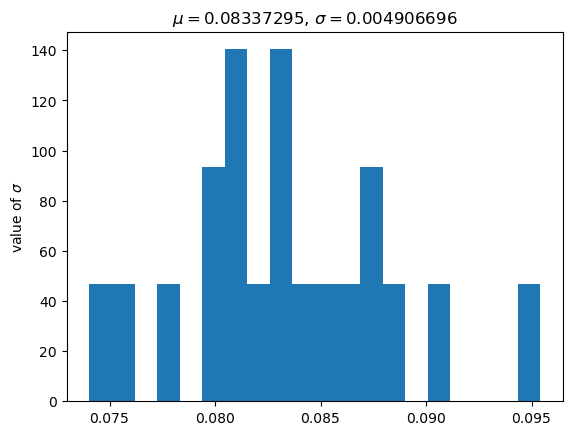

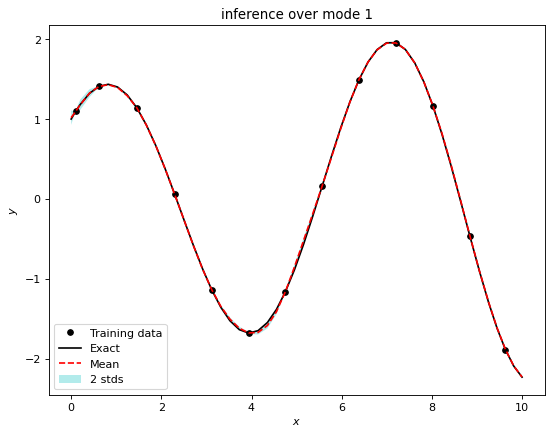

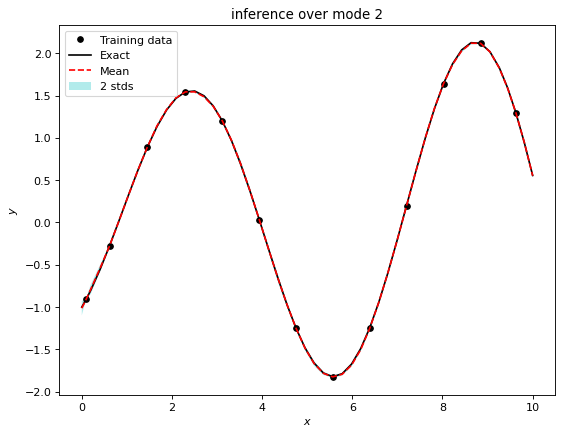

In [9]:
u_pred, r1_pred = model.predict(t_test, samples, processes, pde_fn=None)
plots(u_pred, t_test, u_test, t_u_train, u_train)